# Goals
- [x] Get ebird data from Alex
    - [x] US only (18g Feb17)
    - [ ] Update US data (18g Feb17 -> 20g May18) so it isn't a truncated gz
    - [ ] Try on global data (18g -> 29g -- turns out checklists are dominated by US)
- [ ] ebird.predict_proba(loc, date) -> probs
    - [x] Figure out how to aggregate to make data fit comfortably in mem
    - [x] Make an out-of-core ddf pass over the cols-for-time-space-priors.tsv file to produce the aggregates
    - [ ] Use the aggregates in memory to power the priors model
- [ ] Ensemble audio probs + ebird probs (expose tuning param for weighted combination)
- [ ] See how it improves model validation (e.g. many species should be way closer to few species)

In [ ]:
import geohash
from notebooks import *

# Register a global dask progress bar
dask_progress().register()

relpath = os.path.relpath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# TODO -> potoo.dask

def ddf_divisions_for_dtype(dtype: 'dtype-like', npartitions: int) -> np.ndarray:
    dtype = np.dtype(dtype)
    return list(np.linspace(
        start=np.iinfo(dtype).min,
        stop=np.iinfo(dtype).max,
        num=npartitions + 1,
        endpoint=True,
        dtype=dtype,
    ))

def ddf_checkpoint(
    ddf: dd.DataFrame,
    path: str,
    # TODO Think harder: bad interactions with upstream .compute()'s (e.g. checkpoints without resume, set_index without divisions)
    #   - Addressing this would require a heavier refactor in the user's pipeline, since they'd have to wrap entire
    #     prefixes of the pipeline -- and composing these would increase indentation in an awkward way...
    resume_from_checkpoint=False,
    # Manually surface common kwargs
    engine='auto',  # .to_parquet + .read_parquet
    compression='default',  # .to_parquet
    get=None,  # .compute
    # And provide a way to pass arbitrary kwargs we didn't handle above
    to_parquet=dict(),
    compute=dict(),
    read_parquet=dict(),
) -> dd.DataFrame:
    """
    Checkpoint a ddf to (parquet) file
    - Useful to persist the prefix of a computation before a multi-pass operation like .set_index(divisions=None), which
      needs to force the input ddf once to calculate divisions and then again to do the shuffle
    """
    if resume_from_checkpoint and dask_parquet_file_exists(path):
        print(f'[RESUME from checkpoint: {path}]')  # TODO -> log.info once we upgrade the pipeline below to proper logging
    else:
        (ddf
            .to_parquet(path, compute=False, engine=engine, compression=compression, **to_parquet)
            .compute(get=get, **compute)
        )
    return dd.read_parquet(path, engine=engine, **read_parquet)

def dask_parquet_file_exists(url):
    """Test if a parquet file exists, allowing any dask-friendly url"""
    try:
        # This will read the full <url>/_metadata file, which could be big for a parquet file with many parts
        #   - TODO Get our hands directly on dask's fs module so we can do a more lightweight .exists()
        #   - But match dask's dd.read_parquet(url) behavior, e.g. treat inputs 'foo.parquet' + 'foo.parquet/_metadata' the same
        dd.read_parquet(url)
    except Exception:
        return False
    else:
        return True

def dd_read_parquet_sample(
    path,
    sample: Union[float, List[float]] = None,
    sample_divisions=None,
    sample_npartitions=None,
    sample_repartition_force=False,
    sample_to_parquet=dict(compression='gzip'),
    sample_get=None,  # Default: dask_get_for_scheduler('threads')
    random_state=0,
    **kwargs,
):
    """
    dd.read_parquet with sampling, to make it easy to downsample large files for faster dev iteration
    - Same as dd.read_parquet(path, **kwargs) if sample isn't given
    """
    if sample:
        if isinstance(sample, float):
            sample = [sample]
        in_path = _sample_path(path, *sample[:-1])
        out_path = _sample_path(path, *sample)
        if not (Path(out_path) / '_metadata').exists():
            log.info('Caching sample: %s <- %s' % (out_path, in_path))
            # Read and sample
            ddf = (
                dd.read_parquet(in_path, **kwargs)
                .sample(frac=sample[-1], replace=False, random_state=random_state)
            )
            # Repartition, if requested
            if sample_divisions or sample_npartitions:
                ddf = ddf.repartition(
                    divisions=sample_divisions,
                    npartitions=sample_npartitions,
                    force=sample_repartition_force,
                )
            # Write cached sample
            #   - Use 'threads' if repartitioning, else 'processes', to avoid ipc bottlenecks from the shuffle
            sample_get = sample_get or dask_get_for_scheduler('threads' if sample_npartitions else 'processes')
            (ddf
                .to_parquet(out_path, **sample_to_parquet, compute=False)
                .compute(get=sample_get)
            )
        # log.debug('Reading cached sample: %s' % out_path)
        path = out_path
    return dd.read_parquet(path, **kwargs)

def _sample_path(path: str, *sample: float) -> str:
    return '-'.join([path, *map(str, sample)])

# TODO -> potoo.util

def assert_(cond, msg=None):
    """Raise in an expression instead of a statement"""
    if msg is not None:
        assert cond, msg
    else:
        assert cond

# TODO -> features.util

n_ebird_weeks = 48

def date_to_ebird_week(date: date) -> int:
    """'Week' like ebird barchart weeks: 4 weeks per month, where the 4th week includes all days past 28"""
    return (
        (date.month - 1) * 4  # Week from month (4*[0,11])
        + np.clip(date.day // 7, 0, 3)  # Week of month ([0,3])
        + 1  # 0-indexed week to 1-indexed week ([0,47] -> [1,48])
    )

def normalize_ebird_week(week: int) -> int:
    """
    >>> normalize_ebird_week(1 + np.array([-1, 0, 1]))
    array([48,  1,  2])
    >>> normalize_ebird_week(2 + np.array([-1, 0, 1]))
    array([1,  2,  3])
    >>> normalize_ebird_week(48 + np.array([-1, 0, 1]))
    array([47, 48,  1])
    """
    return (week - 1) % n_ebird_weeks + 1

def geohash4(lat: float, lon: float, precision=4) -> str:
    """
    Map (lat, lon) -> geohash4
    - python-geohash
        - https://github.com/hkwi/python-geohash/wiki
        - https://github.com/hkwi/python-geohash/wiki/GeohashReference
    - How big is a geohash?
        - https://www.movable-type.co.uk/scripts/geohash.html [sf: (38,-122)]
        - https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash
    - Misc
        - https://en.wikipedia.org/wiki/Geohash
        - https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html

    Geohash dims (height is constant, width varies by lat: max at equator, 0 at poles):
    - geohash3: (w, h) ≤ ( 97,  97) mi
    - geohash4: (w, h) ≤ ( 24,  12) mi
    - geohash5: (w, h) ≤ (3.0, 3.0) mi
    - geohash6: (w, h) ≤ (.76, .38) mi
    """
    return np.vectorize(otypes=[str], pyfunc=geohash.encode)(lat, lon, precision=precision)

In [ ]:
# Downsample raw data (in shell)
#   - TODO Downsample by checklist_id instead of line (one species within a checklist) to keep checklist (sampling
#     events) complete, else output priors are junk except for sample=1. This is nontrivial because we have to push the
#     full data volume through far enough to get checklist_id=coalesce(sampling_event_identifier, group_identifier)...
# (
#   set -eux
#   set -o pipefail
#   echo '
#     # 1              #  148m lines
#     # 1     .1 0.1   # 14.8m lines
#     # 0.1   .4 0.04  # 5.91m lines
#     # 0.04  .5 0.02  # 2.96m lines
#     # 0.1   .1 0.01  # 1.48m lines
#     # 0.01  .4 0.004 #  591k lines
#     # 0.004 .5 0.002 #  296k lines
#     # 0.01  .1 0.001 #  148k lines
#   ' | while read in_suf sample_frac out_suf comment; do
#     if [ -z "$in_suf" -o "$in_suf" = '#' ]; then continue; fi
#     raw_f='ebd_US_relFeb-2017.txt.gz'
#     in_f="$raw_f-$in_suf"; out_f="$raw_f-$out_suf"
#     cat "$in_f" \
#       | pv -terb -s"`du -Lhs "$in_f" | field 0`" -cN in \
#       | gunzip \
#       | sample-lines "$sample_frac" --seed=0 --keep-header \
#       | pigz \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# Inspect raw data
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz'        #  18gb,  148m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.1'    # 778mb, 14.8m lines
# ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.01'   # 100mb, 1.48m lines
ebd_tsv_path = f'{data_dir}/ebird/ebd_US_relFeb-2017/ebd_US_relFeb-2017.txt.gz-0.001'  #  12mb,  148k lines
proj_cols = [
    'CATEGORY', 'SCIENTIFIC NAME', 'OBSERVATION COUNT', 'COUNTY CODE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
    'SAMPLING EVENT IDENTIFIER', 'ALL SPECIES REPORTED',
]
ebd_tsv_df = pd.read_csv(ebd_tsv_path, sep='\t', nrows=10000, compression='gzip')
display(
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df))),
    humanize.naturalsize(len(joblib_dumps(ebd_tsv_df[proj_cols]))),
    # df_summary(ebd_tsv_df).T,
    df_summary(ebd_tsv_df[proj_cols]).T,
)

'9.9 MB'

'1.5 MB'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
index,int64,80000,10000,10000,10000,NaN,NaN,0,2499,4999,7499,9999
CATEGORY,object,639319,10000,10000,7,NaN,NaN,domestic,species,species,species,spuh
SCIENTIFIC NAME,object,746281,10000,10000,608,NaN,NaN,Acanthis flammea,Charadrius semipalmatus,Lophodytes cucullatus,Sayornis phoebe,Zosterops japonicus
OBSERVATION COUNT,object,651101,10000,10000,163,NaN,NaN,1,1,3,X,X
COUNTY CODE,object,659150,10000,9975,1316,NaN,NaN,US-AK-013,US-FL-105,US-MI-077,US-OR-003,US-WY-039
LATITUDE,float64,80000,10000,10000,5304,NaN,NaN,19.1,35.6,39.8,42.3,71.4
LONGITUDE,float64,80000,10000,10000,5303,NaN,NaN,-172,-107,-88.1,-77.7,173
OBSERVATION DATE,object,670000,10000,10000,5557,NaN,NaN,1800-01-01,1989-04-30,1998-03-15,2002-06-15,2004-12-31
SAMPLING EVENT IDENTIFIER,object,655180,10000,10000,9883,NaN,NaN,S1000381,S16318134,S25555972,S4519111,S9998747


In [ ]:
# Convert ebd.txt -> proj.tsv (in shell)
#   - ~10x faster to read than raw data: no gunzip + fewer cols
# (
#   set -eux
#   set -o pipefail
#   sufs=(
#     # 0.001
#     # 0.002
#     # 0.004
#     # 0.01
#     # 0.02
#     # 0.04
#     # 0.1
#     # 1
#   )
#   for suf in "${sufs[@]}"; do
#     in_f="ebd_US_relFeb-2017.txt.gz-$suf"
#     out_f="derived/priors/ebd_US_relFeb-2017-1-proj.tsv-$suf"
#     cat "$in_f" \
#       | pv -terb -cN in -s"`du -Lhs "$in_f" | field 0`" \
#       | gunzip \
#       | cut -f4,6,9,17,25,26,27,32,39,40 \
#       | pv -terb -cN out \
#       > "$out_f"
#   done
# )

In [ ]:
# FIXME ebd_US_relFeb-2017.txt.gz looks truncated (maybe the original download didn't complete?)
#
#   # Convert ebd.txt -> proj.tsv (in shell)
#   $ ...
#   + in_f=ebd_US_relFeb-2017.txt.gz-1
#   + out_f=derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   ...
#         out: 11.6GiB 0:13:21 [11.3MiB/s]
#         out: 11.6GiB 0:13:21 [14.9MiB/s]
#   gunzip: (stdin): unexpected end of file
#
#   $ tail -3 derived/priors/ebd_US_relFeb-2017-0-proj.tsv-1
#   species Regulus calendula       2       US-OR-067       45.546725       -122.9678249    2012-03-07      S10112003       1
#   species Recurvirostra americana 13      US-UT-053       37.1810055      -113.7148046    2012-03-18      S10208648       0
#   species Passer domesticus       5       US-WI-097       44.4993598      -89.5568454     2012-01-19      S96324

In [ ]:
# %%snakeviz
# %%prun -l50 -scumtime
# Prototype e2e pipeline in one go, using downsampled data
#   - Output: priors
#   - TODO Why super-linear after the checkpoint? Maybe slow pd groupby -> part dfs are too large -> try more nparts?
#       - Punt: assign-by-index is the bottleneck, but I haven't found a faster way to do that windowing operation...
# Resources:
#   - http://dask.pydata.org/en/latest/dataframe-api.html
#   - http://dask.pydata.org/en/latest/dataframe-performance.html
#   - http://dask.pydata.org/en/latest/dataframe.html
#   - http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.set_index

# sample = 1      #  148m lines,  18gb input, no_chk[?],    chk[1512  + 3713s]
# sample = 0.1    # 14.8m lines, 778mb input, no_chk[?],    chk[ 153  +   87s]
# sample = 0.04   # 5.91m lines, 350mb input, no_chk[?],    chk[?]
# sample = 0.02   # 2.96m lines, 189mb input, no_chk[?],    chk[?]
# sample = 0.01   # 1.48m lines, 100mb input, no_chk[19s],  chk[  16  +    5.0s]
# sample = 0.004  #  591k lines,  43mb input, no_chk[?],    chk[?]
# sample = 0.002  #  296k lines,  23mb input, no_chk[?],    chk[?]
sample = 0.001  #  148k lines,  12mb input, no_chk[2.1s], chk[  1.6 +    0.6s]

ebd_proj_size = 12 * 1024**3
ebd_proj_npartitions = 128
proj_path     = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-{sample}')
setindex_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-{sample}')
priors_path   = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-{sample}')
priors = (

    # Read proj.tsv (raw lines with subset of cols)
    #   - sample=0.001: 148k rows, 12mb
    dd.read_csv(
        proj_path,
        # TODO Tune partitions
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample),
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 10),
        # blocksize=int(ebd_proj_size / ebd_proj_npartitions * sample * 100),
        blocksize=int(ebd_proj_size / ebd_proj_npartitions / 10),  # TODO This seems to work ok...?
        sep='\t',
        dtype={
            # lonlat decimal precision [https://en.wikipedia.org/wiki/Decimal_degrees]
            #   - float32: ~5-6 decimals, ~.1-1m
            #   - float16: ~1-2 decimals, ~1-10km
            'LATITUDE': 'float32',
            'LONGITUDE': 'float32',
            'OBSERVATION COUNT': 'str',  # int | 'X'
            'ALL SPECIES REPORTED': 'float16',  # Smallest dtype for {1, 0, None}
        },
    )
    # .pipe(puts, lambda ddf: 'len[%s]: read_csv' % len(ddf))  # Debug

    # Inspect [high-level perf debugging]
    .pipe(df_inspect, f'\n[read: {proj_path}]', lambda ddf: (
        f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        ddf.reset_index().dtypes.to_frame().T,
        # Heavy [high-level perf debugging]
        # '  [memory_usage by partition]',
        # (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        #     # TODO Add a dtype col to the memory_usage outputs
        #     # .pipe(lambda df: pd.concat(axis=1, objs=[
        #     #     df,
        #     #     ddf.reset_index().dtypes.to_frame().rename({'index': 'Index'}),  # TODO Make this not reorder the index
        #     # ]))
        # ),
    ))

    # Simplify col names
    .rename(columns=lambda c: c.lower().replace(' ', '_'))

    # Drop cols we don't need
    .drop(axis=1, labels=['county_code'])

    # Keep obs with well defined species [https://help.ebird.org/customer/portal/articles/1006825]
    #   - sample=0.001: 144k rows
    .pipe(lambda ddf: ddf[ddf.category.isin(['species', 'domestic', 'issf', 'form'])])
    .drop(axis=1, labels=['category'])
    # .pipe(puts, lambda ddf: 'len[%s]: categories.isin' % len(ddf))  # Debug

    # Keep obs from checklists that represent a complete sampling of all present species
    #   - sample=0.001: 125k rows
    .pipe(lambda ddf: ddf[ddf.all_species_reported == 1])
    .drop(axis=1, labels=['all_species_reported'])
    # .pipe(puts, lambda ddf: 'len[%s]: all_species_reported' % len(ddf))  # Debug

    # Map (sampling_event_identifier, group_identifier) -> checklist_id
    #   - sample=0.001: 125k rows
    #   - Compress from str to int32 ('S10150441' -> 10150441) for ~46% compression (e.g. 24mb -> 13mb)
    #   - Map sampling_event_identifier to pos ('S10150441' -> 10150441) and group_identifier to net ('G554362' -> -554362)
    #   - FIXME Some of these nulls are due to misaligned fields (maybe something funny in the tsv? nontrivial problem -- punt)
    .dropna(subset=['sampling_event_identifier'])
    .assign(checklist_id=lambda ddf: (ddf
        .group_identifier.combine_first(ddf.sampling_event_identifier)
        .str.replace('S', '').str.replace('G', '-').astype(np.int32)
    ))
    .drop(axis=1, labels=['sampling_event_identifier', 'group_identifier'])
    # .pipe(puts, lambda ddf: 'len[%s]: checklist_id' % len(ddf))  # Debug

    # Map (lat, lon) -> geohash4
    #   - sample=0.001: 125k rows
    #   - python-geohash
    #       - https://github.com/hkwi/python-geohash/wiki
    #       - https://github.com/hkwi/python-geohash/wiki/GeohashReference
    #   - How big is a geohash?
    #       - https://www.movable-type.co.uk/scripts/geohash.html [sf: (38,-122)]
    #       - https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash
    #   - Misc
    #       - https://en.wikipedia.org/wiki/Geohash
    #       - https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html
    .dropna(subset=['latitude', 'longitude'])
    .pipe(lambda ddf: ddf.map_partitions(
        meta=ddf._meta.assign(
            geohash4='',
        ),
        func=lambda df: df.assign(
            geohash4=lambda df: geohash4(df.latitude, df.longitude),
        ),
    ))
    .drop(axis=1, labels=['latitude', 'longitude'])
    # .pipe(puts, lambda ddf: 'len[%s]: geohash4' % len(ddf))  # Debug

    # Keep obs with >0 observation_count (including 'X')
    #   - sample=0.001: 125k rows
    .pipe(lambda ddf: ddf[ddf.observation_count != '0'])
    .drop(axis=1, labels=['observation_count'])
    # .pipe(puts, lambda ddf: 'len[%s]: observation_count' % len(ddf))  # Debug

    # Assert our cols and drop any remaining nulls
    #   - sample=0.001: 125k rows
    .pipe(tap, lambda ddf: assert_(
        ddf.columns.tolist() == ['scientific_name', 'observation_date', 'checklist_id', 'geohash4'],
        'Unexpected cols: %s' % ddf.columns.tolist(),
    ))
    .dropna()
    # .pipe(puts, lambda ddf: 'len[%s]: dropna' % len(ddf))  # Debug

    # Map observation_date:str -> observation_week:uint8
    #   - (category would be more compact than uint32/64 in the .parquet, but that ran into problems -- abort)
    .assign(
        observation_date=lambda df: pd.to_datetime(df.observation_date),
        week=lambda df: date_to_ebird_week(df.observation_date.dt),
    )
    .astype({'week': np.uint8})
    .drop(axis=1, labels=['observation_date'])

    # Create categories to compact space usage via dictionary encoding
    #   - WARNING Have to recreate category dtypes after munging meta, else downstream .to_parquet fails on `pd.Index(None)`
    .astype({
        'scientific_name': 'category',
        'geohash4': 'category',  # Max 32**4 = ~1m values -> ~4mb dictionary (separate dictionary per partition df)
    })

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        '\n[map-side ops]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )

    # .set_index to partition once to avoid 3 shuffles below (drop_duplicates, groupby, groupby)
    #   - ddf.set_index doesn't support multiple cols, so add dist_key = hash(week, geohash4)
    #   - Hash to uint16 for ≤64k partitions [alt: ≤256 for uint8]
    #   - [wontfix] uint16 gets unavoidably widened to uint64 by df.set_index [https://github.com/pandas-dev/pandas/issues/16404]
    .assign(dist_key=lambda df: (
        np.vectorize(otypes=[np.uint16], pyfunc=lambda week, geohash4: (
            one(np.frombuffer(
                dtype=np.uint16,
                buffer=hashlib.sha1(f'{week}/{geohash4}'.encode('utf8')).digest()[:2],
            ))
        ))(df.week, df.geohash4)
    ))
    #   - Checkpoint before .set_index
    #       - Why helpful: the timing numbers above show a clean time-complexity split of linear before the chk and super-linear after
    .pipe(df_inspect, f'\n[checkpointing before set_index: {setindex_path}]')
    .pipe(ddf_checkpoint, setindex_path, compression=None,
        get=dask_get_for_scheduler('threads'),  # Procs no good [TODO why?]
        # resume_from_checkpoint=True,  # Re-comment out after measuring perf of .set_index
    )
    .pipe(df_inspect,
        f'\n[checkpointed before set_index: {setindex_path}]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # Heavy [high-level perf debugging]
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )
    #   - Finally do the .set_index
    .pipe(lambda ddf: (ddf
        .set_index('dist_key', divisions=ddf_divisions_for_dtype(ddf.dist_key.dtype,
            # TODO TODO Tune npartitions for groupby's
            # ddf.npartitions,
            # 1,   # sync+prun: 0.01[4.7s]
            # 2,   # sync+prun: 0.01[4.6s]
            # 5,   # sync+prun: 0.01[4.6s]
            10,  # sync+prun: 0.01[5.1s]
            # 20,  # sync+prun: 0.01[6.1s]
            # 40,  # sync+prun: 0.01[8.1s]
        ))
    ))
    #   - HACK Recreate category dtypes after the .set_index, else downstream .to_parquet fails on `pd.Index(None)`
    .pipe(lambda ddf: (ddf
        .astype({k: 'category' for k, v in ddf.dtypes.items() if v.name == 'category'})
    ))

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        '\n[set_index(dist_key)]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
        # '  [memory_usage by partition]',
        # lambda ddf: (ddf
        #     .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
        #     .compute()
        #     .pipe(df_with_totals).reset_index()[:50]
        # ),
    )

    # Do a bunch of map-side groupby's via .map_partitions, relying on the .set_index we just did
    .map_partitions(lambda df: (df

        # Drop duplicate rows since all (checklist, species) should be unique
        #   - sample=0.001: 142k -> 98.7k rows
        #   - Some dupes come from group_identifier vs. sampling_event_identifier: anything with group_identifier is repeated
        #   - Also, the sample=0.001 raw file shows most lines occur once but ~18 lines are repeated ~2500-2800 times <- definitely junk
        .drop_duplicates(
            subset=['week', 'geohash4', 'scientific_name', 'checklist_id'],
            keep='first',
        )

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: drop_duplicates]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Compute n (window)
        #   - Num unique checklist_id's per (week, geohash4)
        #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much
        #   - This assign-by-index is the bottleneck (way slower than the groupby for n_present)
        #       - See cell below for attempts at optimizing -- haven't found any faster approaches yet...
        .reset_index()  # dist_key, from ddf.map_partitions
        .set_index(['dist_key', 'week', 'geohash4'])
        .assign(n=lambda df: (df
            .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
            .checklist_id.nunique()
            .astype(np.uint32)  # TODO uint16 to save space? -- measure max in the data? Or just drop this col entirely?
        ))

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: n]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Compute n_present (group)
        #   - Num checklists per (week, geohash4, scientific_name)
        #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much
        .assign(n_present=1)  # One per (week, geohash4, scientific_name, checklist_id)
        .groupby(observed=True, by=['dist_key', 'week', 'geohash4', 'scientific_name'])
        .agg({
            'n_present': 'sum',
            'n': 'first',  # Passthru; assume unique per group
            # Drop: checklist_id
        })

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: n_present -> p]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # XXX Keep (n_present, n) for simpler query-time aggregation
        # # Compute p, drop n_present
        # .assign(p=lambda df: (
        #     (df.n_present / df.n)
        #     .astype('float16')  # TODO uint8?
        #     # FIXME This turns into float32 after to_parquet
        #     #   - parquet doesn't support float16, so maybe it's getting coerced? [https://drill.apache.org/docs/parquet-format/]
        #     #   - TODO But does fastparquet read not re-cast to the dtype the .parquet file was written from?
        # ))
        # .drop(columns=['n_present'])
        # .pipe(df_reorder_cols, last=['n'])

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: p]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

        # Restore dtypes lost in the index by the groupby's above (e.g. week: uint8 -> uint64)
        .reset_index()
        .astype({
            'week': 'uint8',
        })

        # Restore ['dist_key'] index for ddf.map_partitions
        .set_index(['dist_key'])

        # # Inspect
        # .pipe(df_inspect,
        #     '\n[map_partitions: set_index]',
        #     lambda df: df.reset_index().dtypes.to_frame().T,
        # )

    ))

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        f'\n[map_partitions]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        lambda ddf: ddf.reset_index().dtypes.to_frame().T,
    )

    # Write
    .pipe(df_inspect, f'\n[write: {priors_path}]')
    .pipe(ddf_checkpoint, priors_path,
        compression=None,
        # get=dask_get_for_scheduler('synchronous'),  # Debug
        get=dask_get_for_scheduler('threads'),  # Faster
        # get=dask_get_for_scheduler('processes'),
    )

    # Inspect [high-level perf debugging]
    .pipe(df_inspect,
        f'\n[inspect priors: {priors_path}]',
        lambda ddf: f'npartitions[{ddf.npartitions}], divisions[{ddf.divisions}]',
        # Heavy [high-level perf debugging]
        '  [memory_usage by partition]',
        lambda ddf: (ddf
            .map_partitions(lambda df: df.memory_usage(deep=True).to_frame().T)
            .compute()
            .pipe(df_with_totals).reset_index()[:50]
        ),
    )
    .pipe(tap, lambda ddf: (ddf
        .head(10000)
        .pipe(df_inspect,
            lambda df: df_summary(df).T,
            lambda df: df[:10],
        )
    ))

)


[read: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-1-proj.tsv-0.001]

'npartitions[2], divisions[(None, None, None)]'

,index,CATEGORY,SCIENTIFIC NAME,OBSERVATION COUNT,COUNTY CODE,LATITUDE,LONGITUDE,OBSERVATION DATE,SAMPLING EVENT IDENTIFIER,ALL SPECIES REPORTED,GROUP IDENTIFIER
0,int64,object,object,object,object,float32,float32,object,object,float16,object



[map-side ops]

npartitions[2], divisions[(None, None, None)]

,index,scientific_name,checklist_id,geohash4,week
0,int64,category,int32,category,uint8



[checkpointing before set_index: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-0.001]

[                                                                                          ] | 0% Completed |  0.0s

[###########                                                                               ] | 13% Completed |  0.1s

[##########################                                                                ] | 29% Completed |  0.2s

[##########################################                                                ] | 47% Completed |  0.3s

[###############################################                                           ] | 52% Completed |  0.4s

[###############################################################                           ] | 70% Completed |  0.6s

[###################################################################                       ] | 75% Completed |  0.7s

[###################################################################                       ] | 75% Completed |  0.8s

[###################################################################                       ] | 75% Completed |  0.9s

[##############################################################################            ] | 86% Completed |  1.0s

[####################################################################################      ] | 93% Completed |  1.2s

[####################################################################################      ] | 93% Completed |  1.3s

[####################################################################################      ] | 93% Completed |  1.4s

[#####################################################################################     ] | 95% Completed |  1.5s

[#####################################################################################     ] | 95% Completed |  1.7s

[##########################################################################################] | 100% Completed |  1.8s


[checkpointed before set_index: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-0.001]

npartitions[2], divisions[(None, None, None)]

,index,scientific_name,checklist_id,geohash4,week,dist_key
0,int64,category,int32,category,uint8,uint16



[set_index(dist_key)]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39321, 45874, 52428, 58981, 65535)]

,dist_key,scientific_name,checklist_id,geohash4,week
0,uint64,category,int32,category,uint8



[map_partitions]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39321, 45874, 52428, 58981, 65535)]

,dist_key,week,geohash4,scientific_name,n_present,n
0,uint64,uint8,category,category,int64,uint32



[write: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001]

[                                                                                          ] | 0% Completed |  0.0s

[#                                                                                         ] | 1% Completed |  0.1s

[#                                                                                         ] | 1% Completed |  0.2s

[#                                                                                         ] | 1% Completed |  0.4s

[#                                                                                         ] | 1% Completed |  0.5s

[#                                                                                         ] | 1% Completed |  0.6s

[#                                                                                         ] | 1% Completed |  0.7s

[#                                                                                         ] | 1% Completed |  0.8s

[#                                                                                         ] | 1% Completed |  0.9s

[#                                                                                         ] | 1% Completed |  1.1s

[#                                                                                         ] | 1% Completed |  1.2s

[#####                                                                                     ] | 6% Completed |  1.3s

[##########                                                                                ] | 12% Completed |  1.4s

[######################                                                                    ] | 25% Completed |  1.5s

[###############################################                                           ] | 53% Completed |  1.6s

[###############################################                                           ] | 53% Completed |  1.7s

[###############################################                                           ] | 53% Completed |  1.9s

[###############################################                                           ] | 53% Completed |  2.0s

[##############################################################################            ] | 86% Completed |  2.1s

[##########################################################################################] | 100% Completed |  2.2s


[inspect priors: features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-0.001]

npartitions[10], divisions[(0, 6553, 13107, 19660, 26214, 32767, 39324, 45876, 52432, 58982, 65535)]

  [memory_usage by partition]

[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

,index,Index,week,geohash4,scientific_name,n_present,n,total
0,0,67824,8478,170554,55566,67824,33912,404158
1,0,68496,8562,429850,70893,68496,34248,680545
2,0,69552,8694,171535,56704,69552,34776,410813
3,0,68560,8570,173361,56689,68560,34280,410020
4,0,68152,8519,171917,55713,68152,34076,406529
5,0,66584,8323,429372,70415,66584,33292,674570
6,0,66584,8323,169268,54722,66584,33292,398773
7,0,69616,8702,430130,71173,69616,34808,684045
8,0,63456,7932,163423,54838,63456,31728,384833
9,0,67480,8435,167296,55850,67480,33740,400281


[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 8478 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dist_key,uint64,67824,8478,8478,3324,3232.109,1879.542,0,1606,3215,4844,6550
week,uint8,8478,8478,8478,48,24.032,12.889,1,15,21,35,48
geohash4,category,252474,8478,8478,2518,NaN,NaN,87z9,9vqd,djne,dqcs,f2rd
scientific_name,category,76046,8478,8478,515,NaN,NaN,Acanthis flammea,Chordeiles minor,Melospiza georgiana,Setophaga coronata,Zosterops japonicus
n_present,int64,67824,8478,8478,5,1.028,0.183,1,1,1,1,5
n,uint32,33912,8478,8478,26,4.685,9.071,1,1,2,4,86


,week,geohash4,scientific_name,n_present,n
dist_key,,,,,
0,17,9x0m,Turdus migratorius,1,1
1,8,9tnr,Haemorhous mexicanus,1,2
1,8,9tnr,Campylorhynchus brunneicapillus,1,2
1,23,dnky,Spizella pusilla,1,1
5,48,9zy6,Poecile atricapillus,1,1
6,30,9rxe,Dumetella carolinensis,1,1
7,8,dnh7,Turdus migratorius,1,1
7,21,9qcg,Picoides pubescens,1,1
9,46,9vm9,Recurvirostra americana,1,1


In [ ]:
(priors
    .head(1_000_000)
    .pipe(df_inspect,
        lambda df: df_summary(df).T,
        lambda df: df[:10],
    )
);

[                                                                                          ] | 0% Completed |  0.0s

[##########################################################################################] | 100% Completed |  0.1s

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/dask/dataframe/core.py:4206: UserWarning: Insufficient elements for `head`. 1000000 elements requested, only 8478 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dist_key,uint64,67824,8478,8478,3324,3232.109,1879.542,0,1606,3215,4844,6550
week,uint8,8478,8478,8478,48,24.032,12.889,1,15,21,35,48
geohash4,category,252474,8478,8478,2518,NaN,NaN,87z9,9vqd,djne,dqcs,f2rd
scientific_name,category,76046,8478,8478,515,NaN,NaN,Acanthis flammea,Chordeiles minor,Melospiza georgiana,Setophaga coronata,Zosterops japonicus
n_present,int64,67824,8478,8478,5,1.028,0.183,1,1,1,1,5
n,uint32,33912,8478,8478,26,4.685,9.071,1,1,2,4,86


,week,geohash4,scientific_name,n_present,n
dist_key,,,,,
0,17,9x0m,Turdus migratorius,1,1
1,8,9tnr,Haemorhous mexicanus,1,2
1,8,9tnr,Campylorhynchus brunneicapillus,1,2
1,23,dnky,Spizella pusilla,1,1
5,48,9zy6,Poecile atricapillus,1,1
6,30,9rxe,Dumetella carolinensis,1,1
7,8,dnh7,Turdus migratorius,1,1
7,21,9qcg,Picoides pubescens,1,1
9,46,9vm9,Recurvirostra americana,1,1


In [ ]:
# Try using priors
sample = 1      #  148m txt.gz lines,  18gb txt.gz, 330mb parquet, 177mb df,  13m rows, 4.9s read_parquet, 45s total
# sample = 0.1    # 14.8m txt.gz lines, 778mb txt.gz, 100mb parquet,  57mb df, 4.2m rows,  .6s read_parquet, 10s total
# sample = 0.01   # 1.48m txt.gz lines, 100mb txt.gz,  31mb parquet,  12mb df, 730k rows,  .1s read_parquet, 2.9s total
# sample = 0.001  #  148k txt.gz lines,  12mb txt.gz,   6mb parquet, 3.2mb df,  85k rows,  .1s read_parquet, <1s total
priors_path = relpath(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-{sample}')
priors_ddf = dd.read_parquet(puts(priors_path))
priors_df = (priors_ddf

    .pipe(tap, lambda df: log.info('Materializing ddf -> df...'))
    .compute()
    .reset_index(drop=True)  # Drop dist_key

    # Back compat
    #   - XXX after regenerating priors files with (n_present, n) instead of (p, n)
    .pipe(lambda df: df if 'n_present' in df.columns else (df
        .assign(n_present=lambda df: (df.p * df.n).round().astype(np.int32))
        .drop(columns=['p'])
    ))

    .pipe(tap, lambda df: log.info('Joining sci_name -> species...'))
    .rename(columns={'scientific_name': 'sci_name'})
    .assign(sci_name=lambda df: (df.sci_name
        # TODO Find a more systematic way to align the taxonomies (recent ebird api request vs. Feb17 ebird data dump)
        .str.replace(r' \(Domestic type\)$', '')
        .replace({
            'Anas americana': 'Mareca americana',  # American Wigeon
            'Anas clypeata': 'Spatula clypeata',  # Northern Shoveler
            'Anas cyanoptera': 'Spatula cyanoptera',  # Cinnamon Teal
            'Anas discors': 'Spatula discors',  # Blue-winged Teal
            'Anas falcata': 'Mareca falcata',  # Falcated Duck
            'Anas formosa': 'Sibirionetta formosa',  # Baikal Teal
            'Anas penelope': 'Mareca penelope',  # Eurasian Wigeon
            'Anas querquedula': 'Spatula querquedula',  # Garganey
            'Anas strepera': 'Mareca strepera',  # Gadwall
            'Chen caerulescens': 'Anser caerulescens',  # Snow Goose
            'Chen canagica': 'Anser canagicus',  # Emperor Goose
            'Chen rossii': 'Anser rossii',  # Ross's Goose
            'Larus thayeri': 'Larus glaucoides thayeri',  # Thayer's Gull [subspecies, won't match]
            'Porphyrio martinicus': 'Porphyrio martinica',  # Purple Gallinule (/ American Purple Gallinule)
            'Procelsterna cerulea': 'Anous ceruleus',  # Blue-gray Noddy (/ Blue Noddy)
            'Serinus mozambicus': 'Crithagra mozambica',  # Yellow-fronted Canary
        })
    ))
    .set_index('sci_name')
    .join(how='left', other=metadata.species.df[['sci_name', 'shorthand']].set_index('sci_name'))
    .reset_index()  # sci_name
    .rename(columns={'shorthand': 'species'})
    .pipe(df_reorder_cols, first=['species'])

    .pipe(tap, lambda df: log.info("Checking for unknown sci_name's..."))
    .pipe(tap, lambda df: (df
        [['sci_name', 'species']]
        .drop_duplicates()
        .query('species.isnull()')
        .pipe(lambda df: None if df.empty else [
            log.warn("Unknown sci_name's in priors_df:"),
            display(df),
        ])
    ))
    .drop(columns=['sci_name'])  # Drop sci_name
    .dropna(subset=['species'])  # Drop unknown sci_name's

    .pipe(tap, lambda df: log.info('Setting indexes for query-time joins...'))
    .astype({'week': 'category'})  # More compact than uint64
    .set_index(['week', 'geohash4'])
    .sort_index()

    .pipe(tap, lambda df: log.info('Inspecting...'))
    .pipe(df_inspect,
        lambda df: (df
            .reset_index().memory_usage(deep=True, index=False)
            .to_frame().pipe(df_with_totals_row).applymap(humanize.naturalsize)
        ),
        lambda df: df_summary(df.reset_index()).T,
        lambda df: df[:10],
    )

)

features/data/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-3-priors.parquet-1


[22:43:34.567] INFO   Materializing ddf -> df...
[                                                                                          ] | 0% Completed |  0.0s

[#                                                                                         ] | 1% Completed |  0.1s

[###                                                                                       ] | 3% Completed |  0.2s

[#####                                                                                     ] | 6% Completed |  0.3s

[#######                                                                                   ] | 8% Completed |  0.4s

[#########                                                                                 ] | 10% Completed |  0.5s

[###########                                                                               ] | 12% Completed |  0.7s

[#############                                                                             ] | 15% Completed |  0.8s

[###############                                                                           ] | 17% Completed |  0.9s

[#################                                                                         ] | 19% Completed |  1.0s

[###################                                                                       ] | 21% Completed |  1.1s

[#####################                                                                     ] | 24% Completed |  1.2s

[#######################                                                                   ] | 26% Completed |  1.3s

[##########################                                                                ] | 28% Completed |  1.4s

[############################                                                              ] | 31% Completed |  1.5s

[##############################                                                            ] | 33% Completed |  1.6s

[################################                                                          ] | 35% Completed |  1.7s

[##################################                                                        ] | 37% Completed |  1.8s

[####################################                                                      ] | 40% Completed |  1.9s

[######################################                                                    ] | 42% Completed |  2.0s

[########################################                                                  ] | 44% Completed |  2.1s

[##########################################                                                ] | 46% Completed |  2.2s

[############################################                                              ] | 49% Completed |  2.3s

[##############################################                                            ] | 51% Completed |  2.4s

[################################################                                          ] | 53% Completed |  2.5s

[##################################################                                        ] | 56% Completed |  2.6s

[####################################################                                      ] | 58% Completed |  2.7s

[######################################################                                    ] | 60% Completed |  2.8s

[########################################################                                  ] | 63% Completed |  2.9s

[##########################################################                                ] | 65% Completed |  3.0s

[#############################################################                             ] | 68% Completed |  3.1s

[###############################################################                           ] | 70% Completed |  3.3s

[#################################################################                         ] | 72% Completed |  3.4s

[###################################################################                       ] | 74% Completed |  3.5s

[#####################################################################                     ] | 77% Completed |  3.6s

[#######################################################################                   ] | 79% Completed |  3.7s

[#########################################################################                 ] | 81% Completed |  3.8s

[###########################################################################               ] | 84% Completed |  3.9s

[#############################################################################             ] | 86% Completed |  4.0s

[###############################################################################           ] | 88% Completed |  4.1s

[##################################################################################        ] | 91% Completed |  4.2s

[####################################################################################      ] | 93% Completed |  4.3s

[######################################################################################    ] | 95% Completed |  4.4s

[########################################################################################  ] | 97% Completed |  4.5s

[##########################################################################################] | 100% Completed |  4.6s

[22:43:42.321] INFO   Joining sci_name -> species...


[22:43:54.897] INFO   Checking for unknown sci_name's...


[22:43:56.134] WARN   Unknown sci_name's in priors_df:


,sci_name,species
827398,Anser sp.,nan
6297335,Larus glaucoides thayeri,nan
7648965,Oceanodroma leucorhoa/socorroensis (dark-rumped),nan


[22:43:57.133] INFO   Setting indexes for query-time joins...


[22:44:09.181] INFO   Inspecting...


,0
week,13.4 MB
geohash4,28.4 MB
species,27.7 MB
n,53.5 MB
n_present,53.5 MB
0,176.6 MB


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
index,int64,107064456,13383057,13383057,13383057,6.692e+06,3.863e+06,0,3345764,6691528,10037292,13383056
week,category,13384721,13383057,13383057,48,NaN,NaN,1,15,23,35,48
geohash4,category,28362704,13383057,13383057,15430,NaN,NaN,87z9,dp8w,9rvq,9wyh,bkxt
species,category,27745202,13383057,13383057,1072,NaN,NaN,WFWD,SNPL,LOSH,PROW,PTWH
n,uint32,53532228,13383057,13383057,741,3.726e+01,7.470e+01,1,5,13,38,2499
n_present,int32,53532228,13383057,13383057,826,5.891e+00,1.524e+01,1,1,2,5,1767


species   n  n_present
week geohash4                       
1    87z9        COMY  24         11
     87z9        RCPA  24          1
     87z9        NOPI  24          7
     87z9        GWTE  24          6
     87z9        MALL  24          1
     87z9        RUTU  24          9
     87z9        CAEG  24         16
     87z9        SAND  24          6
     87z9        REKN  24          3
     87z9        LESA  24          1

In [ ]:
# Try using priors
def ebird_species_probs(
    priors_df: pd.DataFrame,
    lat: float,
    lon: float,
    date: date,
    week_radius=(-1, 1),
    geohash4_radius=1,
    **kwargs,
) -> 'pd.DataFrame[species, prob]':
    """
    Map (lat, lon, date) -> species probs
    - python-geohash
        - https://github.com/hkwi/python-geohash/wiki
        - https://github.com/hkwi/python-geohash/wiki/GeohashReference
    - How big is a geohash?
        - https://www.movable-type.co.uk/scripts/geohash.html [sf: (38,-122)]
        - https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash
    - Misc
        - https://en.wikipedia.org/wiki/Geohash
        - https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html

    Geohash dims (height is constant, width varies by lat: max at equator, 0 at poles):
    - geohash3: (w, h) ≤ ( 97,  97) mi
    - geohash4: (w, h) ≤ ( 24,  12) mi
    - geohash5: (w, h) ≤ (3.0, 3.0) mi
    - geohash6: (w, h) ≤ (.76, .38) mi
    """

    # Params
    #   - Current week ± week_radius weeks
    #   - Geohash + 8 neighbors, repeated geohash4_radius many times
    if isinstance(week_radius, int):
        week_radius = (-week_radius, week_radius)
    weeks = set(normalize_ebird_week(date_to_ebird_week(date.today()) + np.arange(week_radius[0], week_radius[1] + 1)))
    geohash4s = {np.asscalar(geohash4(lat, lon))}
    _expanded = set()
    for _ in range(geohash4_radius):
        for g in geohash4s - _expanded:
            geohash4s.update(geohash.neighbors(g))  # (.expand(g) = [g] + .neighbors(g))
            _expanded.add(g)

    return (priors_df

        # Query
        #   - TODO Is .loc faster than .join? [https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-label]
        .pipe(tap, lambda df: assert_(df.index.names == ['week', 'geohash4']))
        .join(how='inner', other=(
            pd.DataFrame(dict(week=week, geohash4=geohash4) for week in weeks for geohash4 in geohash4s)
            .set_index(['week', 'geohash4'])
        ))
        .pipe(tap, lambda df: None if priors_df is globals().get('_df') else globals().update(_df=df))  # XXX Debug faster
        .reset_index()  # week, geohash4

        # Agg (n, n_present) over (week, geohash4) neighborhood
        .pipe(_ebird_species_probs_agg, **{'groupby': ['species'], 'agg': ['week', 'geohash4'], **kwargs})

    )

def _ebird_species_probs_agg(df, groupby: List[str], agg: List[str], drop=True):
    return (df

        # Aggregate n over agg neighborhood (e.g. (week, geohash))
        .assign(n=lambda df: df.groupby(agg).n.first().sum())
        .pipe(lambda df: df if not drop else df.drop(columns=agg))

        # Aggregate n_present over agg neighborhood (e.g. (week, geohash))
        #   - HACK .groupby on species:category produced bogus counts (e.g. TRBL 244 i/o 4); use species:str as a workaround
        .astype({'species': 'str', **({} if 'week' in agg else {'week': 'int'})})
        .pipe(lambda df: (df
            .groupby(observed=True, as_index=False, by=groupby)
            .agg({
                'n_present': 'sum',
                **{k: 'first' for k in df.columns if k not in ['n_present', *groupby]},
            })
        ))
        .astype({'species': metadata.species.df.shorthand.dtype, **({} if 'week' in agg else {'week': 'int'})})

        # Compute p
        .assign(p=lambda df: df.n_present / df.n)

    )

# Params
(lat, lon, date) = (37.9, -122, date.today())  # Orinda (includes: SF, Berkeley hills, Mt Diablo, Marin)

# # XXX Debug faster
# weeks = normalize_ebird_week(date_to_ebird_week(date.today()) + np.arange(-week_radius, week_radius + 1))
# geohash4s = geohash.expand(np.asscalar(geohash4(lat, lon)))
# _df = (priors_df
#     .join(how='inner', other=(
#         pd.DataFrame(dict(week=week, geohash4=geohash4) for week in weeks for geohash4 in geohash4s)
#         .set_index(['week', 'geohash4'])
#     ))
# )

res = (
    priors_df
    # _df  # XXX Debug faster
    .pipe(ebird_species_probs, lat, lon, date,
        groupby=['species'], agg=['week', 'geohash4'],
        week_radius=1, geohash4_radius=1,
    )
    # Replace species -> longhand
    .set_index('species')
    .join(how='left', other=metadata.species.df.set_index('shorthand')[['longhand']])
    .reset_index(drop=True)  # species
    .pipe(df_reorder_cols, first=['longhand'])
    # Sort and inspect
    # .sort_index()
    .sort_values('n_present', ascending=False).reset_index(drop=True)
    .pipe(df_inspect, lambda df: df.nunique())
    .pipe(tap, lambda df: display(pd.concat([df[:5], df[len(df)//2:len(df)//2+5], df[-5:]])))
)

longhand     415
week          48
n_present    487
n              1
p            487
dtype: int64

,longhand,week,n_present,n,p
0,Anna's Hummingbird - ANHU,48,703,965,0.728
1,White-crowned Sparrow - WCSP,48,688,965,0.713
2,Anna's Hummingbird - ANHU,36,674,965,0.698
3,Yellow-rumped Warbler - YRWA,48,672,965,0.696
4,Anna's Hummingbird - ANHU,4,660,965,0.684
5791,White-breasted Nuthatch - WBNU,6,26,965,0.027
5792,Merlin - MERL,39,26,965,0.027
5793,Long-billed Dowitcher - LBDO,17,26,965,0.027
5794,Western Tanager - WETA,21,26,965,0.027
5795,House Wren - HOWR,43,26,965,0.027


In [ ]:
# Query priors -> barcharts (slow)
barcharts_df = (
    # priors_df
    _df  # XXX Debug faster
    .pipe(ebird_species_probs, lat, lon, date, groupby=['species', 'week'], agg=['geohash4'],
        week_radius=24, geohash4_radius=1,
    )
)

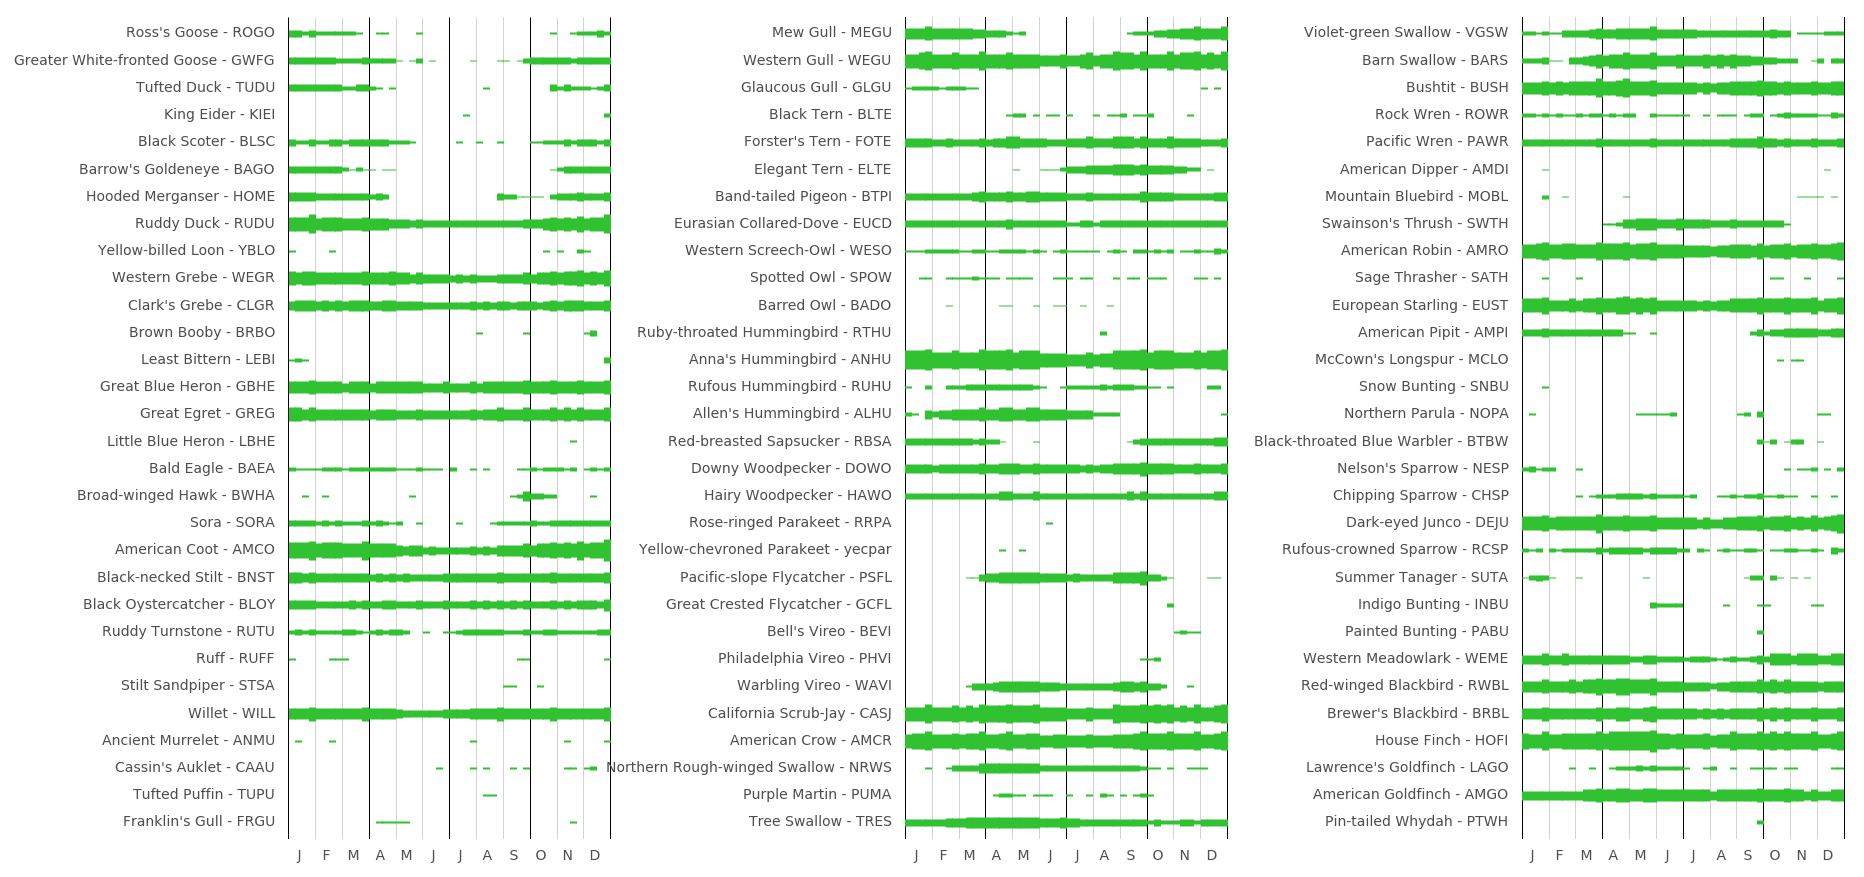

<ggplot: (-9223372036535858295)>

In [ ]:
# Plot barcharts
(barcharts_df
    .pipe(plot_barchart,
        # downsample_sp=30,  cols=1, width_per_col=4,    aspect_per_col=1.25,  # Good examle of 1 col
        # downsample_sp=30,  cols=3, width_per_col=14/3, aspect_per_col=0.278, # Great (better than 2 col)
        downsample_sp=90,  cols=3, width_per_col=14/3, aspect_per_col=0.833, # Great (better than 2 col)
        # downsample_sp=170, cols=3, width_per_col=14/3, aspect_per_col=1.07,  # Great
        # downsample_sp=250, cols=4, width_per_col=5,    aspect_per_col=1.04,  # Great (width 18-22)
        # downsample_sp=300, cols=5, width_per_col=24/5, aspect_per_col=1.00,  # Great (almost full on sp)
        # downsample_sp=415, cols=6, width_per_col=4,    aspect_per_col=1.15,  # Good (room for more sp)
    )
)

In [ ]:
DEBUGGING_BELOW

In [ ]:
%%prun -l50 -scumtime
# %%snakeviz
# Can we optimize assign-by-index? [nope, couldn't find anything faster...]
# sample = 0.04
# sample = 0.02
# sample = 0.01
sample = 0.004
display(
    dd.read_parquet(f'{data_dir}/ebird/ebd_US_relFeb-2017/derived/priors/ebd_US_relFeb-2017-2-chk-setindex.parquet-{sample}')
    .pipe(df_inspect, lambda ddf: 'npartitions: %s' % ddf.npartitions)
    # .head(1_000, compute=False)
    .map_partitions(lambda df: (df

        # XXX Compat
        .set_index('dist_key')

        # Drop duplicate rows since all (checklist, species) should be unique
        #   - sample=0.001: 142k -> 98.7k rows
        #   - Some dupes come from group_identifier vs. sampling_event_identifier: anything with group_identifier is repeated
        #   - Also, the sample=0.001 raw file shows most lines occur once but ~18 lines are repeated ~2500-2800 times <- definitely junk
        .drop_duplicates(
            subset=['week', 'geohash4', 'scientific_name', 'checklist_id'],
            keep='first',
        )

        # Compute n (window)
        #   - Num unique checklist_id's per (week, geohash4)
        #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much

        # Bottleneck: assign-by-index (way slower than the groupby for n_present)
        .reset_index()  # dist_key, from ddf.map_partitions
        .set_index(['dist_key', 'week', 'geohash4'])
        .assign(n=lambda df: (df
            .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
            .checklist_id.nunique()
            .astype(np.uint32)  # TODO uint16 to save space? -- measure max in the data? Or just drop this col entirely?
        ))
        # .sort_index()  # XXX Debug

        # # .groupby().transform()? [nope, way slower]
        # .pipe(df_inspect, lambda df: 'all: %s' % len(df))
        # .sort_values(['dist_key', 'week', 'geohash4'])
        # [:100]
        # .pipe(df_inspect, lambda df: '[:100]: %s' % len(df))
        # .reset_index()
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # # .checklist_id.nunique()
        # .pipe(df_inspect, lambda df: 'groupby: %s' % len(df))
        # .transform('nunique')
        # .pipe(df_inspect, lambda df: 'transform: %s' % len(df))
        # .head(2)
        # .pipe(df_inspect, lambda df: 'head: %s' % len(df))
        # # [:1]
        # # .transform

        # # .groupby().transform()? [nope, way slower]
        # .sort_values(['dist_key', 'week', 'geohash4'])
        # [:100]
        # .reset_index()
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # # .checklist_id.nunique()
        # .transform({'checklist_id': np.max})
        # .head(2)
        # # [:1]
        # # .transform

        # # .assign on a simple RangeIndex instead of the rich ['dist_key', 'week', 'geohash4'] index? [nope, can't make it work]
        # # .pipe(df_inspect, 'in', lambda df: df[:1])
        # .reset_index()  # dist_key, from ddf.map_partitions
        # # .pipe(df_inspect, 'reset_index', lambda df: df[:1])
        # .assign(n=lambda df: (df
        #     .reset_index()  # RangeIndex -> .index
        #     .pipe(df_inspect, 'reset_index_1', lambda x: x[:3])
        #     .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        #     .pipe(df_inspect, 'groupby', lambda g: next(iter(g))[-1][:3])
        #     .checklist_id.nunique()
        #     .pipe(df_inspect, 'nunique', lambda x: x[:3])
        #     # .astype(np.uint32)  # TODO Can we be more aggressive to save space? Or should we drop this col entirely?
        #     .reset_index().checklist_id
        #     .pipe(df_inspect, 'reset_index_2', lambda x: x[:3])
        # ))
        # # .pipe(df_inspect, 'assign', lambda df: df[:1])
        # .set_index(['dist_key', 'week', 'geohash4'])
        # .sort_index()  # XXX Debug

        # # Do less in .assign? [nope, nothing to remove]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .set_index(['dist_key', 'week', 'geohash4'])
        # # .sort_index()  # XXX Debug
        # .assign(n=lambda df: (df
        #     .groupby(sort=False, observed=True, by=['dist_key', 'week', 'geohash4'])
        #     .checklist_id.nunique()
        #     # .astype(np.uint32)  # TODO Can we be more aggressive to save space? Or should we drop this col entirely?
        #     # .pipe(df_inspect, 'other', lambda df: df.to_frame()[:1])
        # ))
        # # .sort_index()  # XXX Debug

        # # .join instead of .assign? [nope, as fast but no faster than assign-by-index above]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .set_index(['dist_key', 'week', 'geohash4'])
        # # .sort_index()  # XXX Debug
        # .pipe(lambda df: (df
        #     # .pipe(df_inspect, 'join', lambda df: df[:1])
        #     .join(how='left', other=(df
        #         .groupby(sort=False, observed=True, by=['dist_key', 'week', 'geohash4'])
        #         .checklist_id.nunique()
        #         .to_frame().rename(columns={'checklist_id': 'n'})
        #         # .pipe(df_inspect, 'other', lambda df: df[:1])
        #         .astype(np.uint32)  # TODO Can we be more aggressive to save space? Or should we drop this col entirely?
        #     ))
        # ))
        # # .sort_index()  # XXX Debug

        # # .groupby().apply() instead of .assign? [nope, way slower than assign-by-index]
        # # [:10]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # .pipe(df_inspect, 'groupby\ngroupby', lambda g: next(iter(g))[-1][:3])
        # .apply(lambda g: (g
        #     # .assign(n=g.checklist_id.nunique())  # TODO
        # ))
        # .pipe(df_inspect, 'apply\napply', lambda df: df[:3])

        # # .groupby().concat instead of .assign? [nope, way slower than assign-by-index]
        # # [:10]
        # .reset_index()  # dist_key, from ddf.map_partitions
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4'])
        # .pipe(df_inspect, 'groupby\ngroupby', lambda g: next(iter(g))[-1][:3])
        # .pipe(lambda gs: pd.concat(
        #     g
        #     # g.assign(n=g.checklist_id.nunique())  # TODO
        #     for ix, g in gs
        # ))

        # # Disable, since this isn't the bottleneck
        # # Compute n_present (group)
        # #   - Num checklists per (week, geohash4, scientific_name)
        # #   - WARNING observed=True else groupby blows up all geohash4.cat x scientific_name.cat, which is way too much
        # .assign(n_present=1)  # One per (week, geohash4, scientific_name, checklist_id)
        # .groupby(observed=True, by=['dist_key', 'week', 'geohash4', 'scientific_name'])
        # .agg({
        #     'n_present': 'sum',
        #     # 'n': 'first',  # Passthru; assume unique per group
        #     # Drop: checklist_id
        # })

    ))
    .compute(
        get=dask_get_for_scheduler('synchronous'),  # Debug
        # get=dask_get_for_scheduler('threads'),  # Faster
        # get=dask_get_for_scheduler('processes'),
    )

    .pipe(df_inspect, len, lambda df: df.reset_index().dtypes.to_frame().T)
    # .query('n_present > 1')
    [:30]
)

In [ ]:
# Prototype groupby + agg
(df

    # Compute n (window)
    #   - Num unique checklist_id's per (week, geohash4)
    .set_index(['week', 'geohash4'])
    .assign(n=lambda df: (df
        .groupby(observed=True, by=['week', 'geohash4'])
        .checklist_id.nunique()
    ))

    # Compute n_present (group)
    #   - Num checklists per (week, geohash4, scientific_name)
    .assign(n_present=1)  # One per (week, geohash4, scientific_name, checklist_id)
    .groupby(observed=True, by=['week', 'geohash4', 'scientific_name'])
    .agg({
        'n_present': 'sum',
        'n': 'first',  # Passthru; assume unique per group
        # 'checklist_id'  # Drop
    })

    # Compute p, drop n_present
    .assign(p=lambda df: (
        (df.n_present / df.n)
        .astype('float16')  # TODO uint8?
    ))
    .drop(columns=['n_present'])
    .pipe(df_reorder_cols, last=['n'])

    # Inspect
    .sort_index()
    # .query('n*p > 1')
    # .shape
    [:30]
)

In [ ]:
# Measure size of each col by writing out to .parquet (df_summary isn't accurate with category dtypes)
cols = dd.read_parquet(ebd_proj_path).columns
for i, col in enumerate(cols):
    log.info('col %s/%s: %s' % (i+1, len(cols), col))
    (
        dd_read_parquet_sample(
            ebd_proj_path,
            # sample=None,  # 1.48b
            # sample=.1, sample_npartitions=8,  # 148m
            sample=[.1, .1],  # 14.8m
            # sample=[.1, .1, .1],  # 1.48m
            # columns=[col],  # XXX
        )
        [[col]]
        .to_parquet(f'/tmp/junk-ebd-col-{col}.parquet', compute=False,
            # compression='gzip',
            compression=None,
        )
        # .compute(get=dask_get_for_scheduler('threads'))
        .compute(get=dask_get_for_scheduler('processes'))
    )